In [1]:
from data_process import data_processing

# Combine all data files into one. Combined data saved at <output_path>
data_path = "./data/"
output_path = "./result/"
data_processing(data_path, 2018, output_path)
data_processing(data_path, 2019, output_path)
data_processing(data_path, 2020, output_path)

/Users/yao/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


csv_path: ['./data/2018/2018流量数据及标签-002180.SZ.flux1-策略五- E7200-2018-10s.csv', './data/2018/2018流量数据及标签-600285.SH.flux.-差商策略 E7200-2018_1s.csv', './data/2018/2018流量数据及标签-002019.SZ.flux5-策略三 E144000-2018-5s.csv', './data/2018/2018流量数据及标签-603825.SH.flux.-差商策略 E7200-2018-1s.csv', './data/2018/2018流量数据及标签-002675.SZ.flux5-差商策略 E14400-2018-5s.csv', './data/2018/2018流量数据及标签-600519.SH.flux1-策略三 E144000-2018-10s.csv', './data/2018/2018流量数据及标签-600036.SH.flux5-策略五- E3600-2018-5s.csv', './data/2018/2018流量数据及标签-300059.SZ.flux1-策略三 E144000-2018-10s.csv', './data/2018/2018流量数据及标签-600660.SH.flux5-策略五- E600-2018-5s.csv', './data/2018/2018流量数据及标签-600403.SH.flux5-差商策略 E72000-2018-5s.csv', './data/2018/2018流量数据及标签-000960.SZ.flux1-策略五- E7200-2018_10s.csv', './data/2018/2018流量数据及标签-300003.SZ.flux1-策略三 E30-2018-10s.csv', './data/2018/2018流量数据及标签-000833.SZ.flux1-差商策略 E144000-2018_10s.csv', './data/2018/2018流量数据及标签-002352.SZ.flux.-策略五- E144000-2018-1s.csv', './data/2018/2018流量数据及标签-002032.SZ.flux1-策略五- E3600-20

In [2]:
import pandas as pd
import numpy as np
import os

# load dataset from combined data
columns = [' E30',' E90',' E240',' E600',' E1500',' E3600',' E7200',' E14400',' E72000',' E144000','label_tfm']
data_18 = pd.read_csv(os.path.join(output_path, "2018processed_data.csv"))
data_19 = pd.read_csv(os.path.join(output_path, "2019processed_data.csv"))
data_20 = pd.read_csv(os.path.join(output_path, "2020processed_data.csv"))
features = columns[:-1]

# 2018, 2019 as training dataset; 2020 as test dataset. Use only buy-points.
data_18_buy = data_18.loc[data_18["action_duo"] == 100].reset_index(drop=True)
data_19_buy = data_19.loc[data_19["action_duo"] == 100].reset_index(drop=True)
data_20_buy = data_20.loc[data_20["action_duo"] == 100].reset_index(drop=True)
train = pd.DataFrame()
train = train.append(data_18_buy[columns])
train = train.append(data_19_buy[columns])
test = data_20_buy[columns]

# seperate data and labels
X_train = train[features]
y_train = train[columns[-1]]
X_test = test[features]
y_test = test[columns[-1]]


# normalization
for feature in features:
    X_train[feature] = (X_train[feature]-X_train[feature].mean()) / X_train[feature].std()
    test[feature] = (test[feature] - test[feature].mean()) / test[feature].std()

X_train.head()

/Users/yao/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yao/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,E30,E90,E240,E600,E1500,E3600,E7200,E14400,E72000,E144000
0,-0.085518,-0.115638,-0.167411,-0.251334,-0.263063,-0.229080,-0.197287,-0.198874,-0.088086,-0.025380
1,-0.080665,-0.106847,-0.162333,-0.243277,-0.257293,-0.217352,-0.226985,-0.179899,-0.117286,-0.232752
2,-0.085518,-0.115638,-0.167754,-0.251425,-0.260631,-0.237619,-0.238450,-0.170440,-0.127567,-0.260504
3,-0.085518,-0.115638,-0.167743,-0.251816,-0.260794,-0.237479,-0.239029,-0.167860,-0.103975,-0.184817
4,-0.085518,-0.115638,-0.165651,-0.239332,-0.252784,-0.203529,-0.220847,-0.188989,-0.201038,-0.239511


In [20]:
from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.datasets import  make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# build XGBoost model
# lower <scale_pos_weight> can result more total selection points
# good <n_estimators> can result higher TP rate
model = XGBClassifier(learning_rate =0.1,
 eta=0.05,
 n_estimators=3000,
 max_depth=3,
 min_child_weight=1,
 subsample=.2,
 colsample_bytree=0.5,
 reg_lambda=.07,
 nthread=5,
 scale_pos_weight=.8,
 seed=27)

# fit the model
model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Confusion matrix: {}".format(confusion_matrix(y_test, predictions)))

/Users/yao/.pyenv/versions/3.6.4/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion matrix: [[ 34 101]
 [ 42 250]]


In [21]:
# save selected trading points to file "selection.csv".
data_buy = data_20_buy.copy()
data_buy['predict_label'] = predictions
data_sell = data_20.loc[data_20["action_duo"] == -100].reset_index(drop=True)
data_sell['predict_label'] = predictions
data_output = pd.DataFrame()
data_output = data_output.append(data_buy)
data_output = data_output.append(data_sell)
data_output = data_output.sort_values(by=[' id', 'time'])
print(data_output)
data_output.to_csv(os.path.join(output_path, "selection.csv"), encoding="utf_8_sig", index=False)

                    time          id   close   volume    amount       E30  \
390  2020-02-10 11:08:50   000833.SZ    4.63   2210.0   10217.3   113.200   
390  2020-02-24 09:36:50   000833.SZ    4.96   2180.0   10834.5 -1763.200   
391  2020-03-05 10:28:50   000833.SZ    5.10   6000.0   30582.6  1401.752   
391  2020-04-02 10:14:50   000833.SZ    5.05    460.0    2326.8  -282.600   
392  2020-05-27 09:47:50   000833.SZ    4.60    680.0    3128.0     0.000   
..                   ...         ...     ...      ...       ...       ...   
92   2020-10-30 11:28:41   603825.SH   31.47    300.0    9442.0  -349.000   
93   2020-11-02 13:01:41   603825.SH   30.27   1400.0   42378.0    76.000   
93   2020-11-03 14:14:41   603825.SH   30.77  12400.0  381661.0  -148.000   
94   2020-11-04 09:30:41   603825.SH   31.09      0.0       0.0   461.000   
94   2020-11-04 10:18:41   603825.SH   31.02      0.0       0.0    35.000   

          E90       E240       E600          E1500  ...          卖出价格  \
39

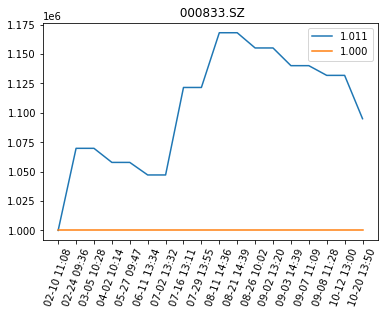

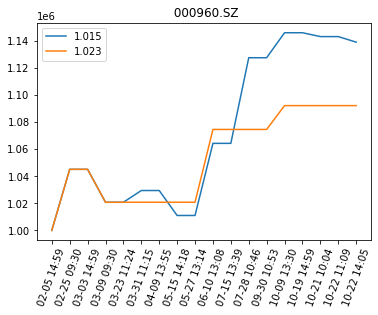

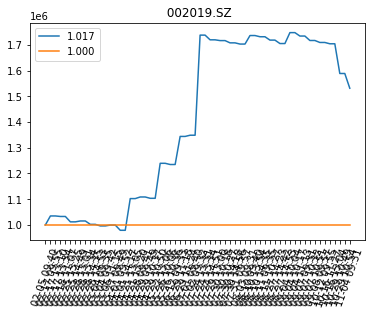

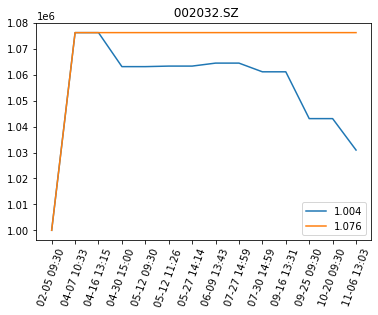

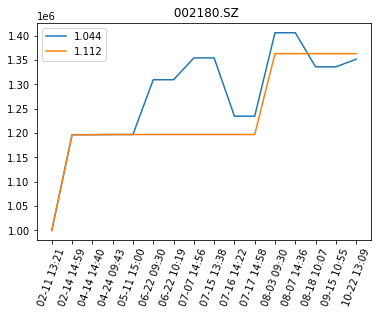

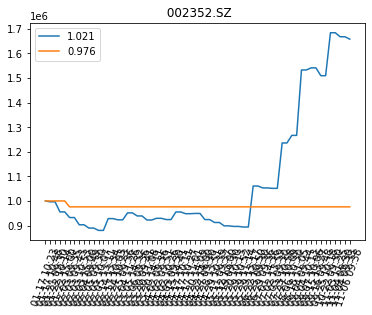

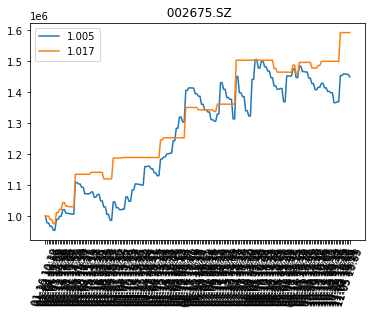

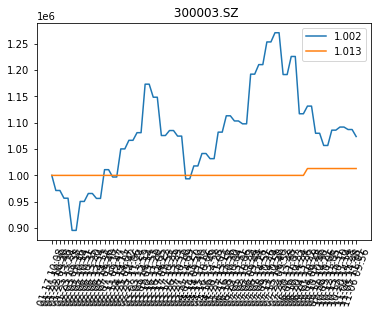

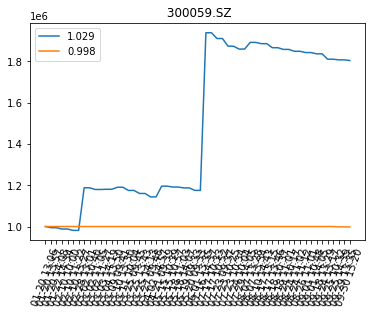

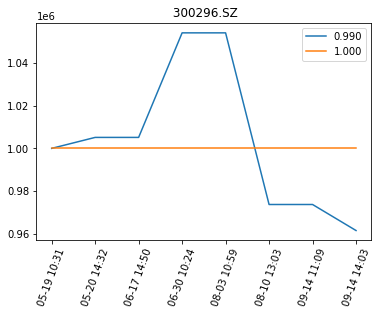

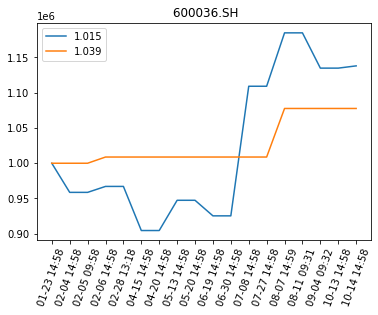

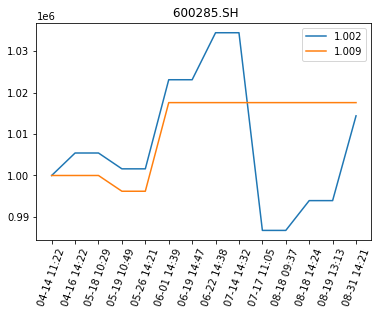

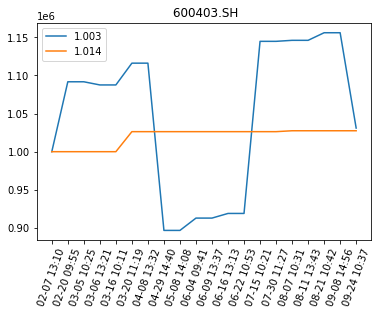

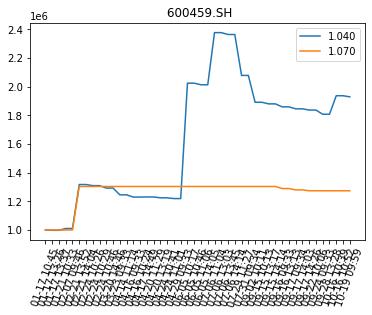

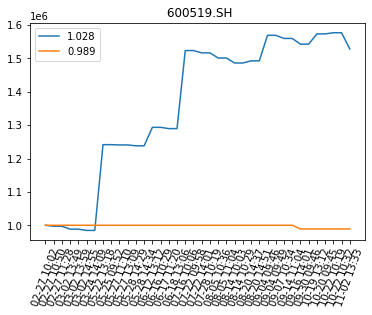

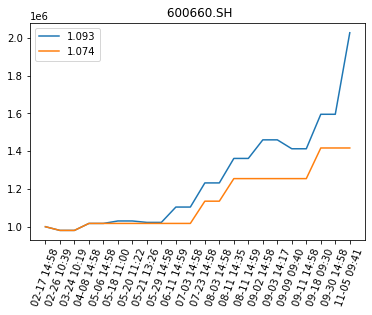

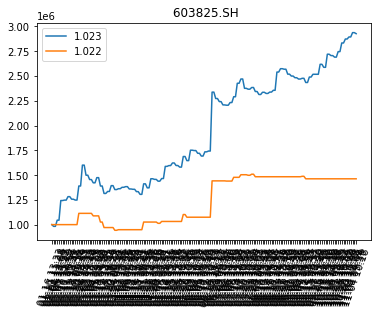

In [22]:
# plot net values
import matplotlib.pyplot as plt

# collect the index of all stocks
stocks = pd.unique(data_output[" id"])
net_origin = 1e6

# for each stock
for stock in stocks:
    # before selection
    one_stock = data_output.loc[data_output[" id"] == stock].reset_index(drop=True)
    time_before_selection = list(one_stock["time"].map(lambda x:x[5:16]))
    net_value_before_selection = list(one_stock["买入价格"] + one_stock["做多剩余资金"])
    # averate gain rate for each trading
    avg_rates_before_selection = \
        (net_value_before_selection[-1]-net_value_before_selection[0])/len(one_stock)*2/net_origin + 1
    
    # after selection
    one_stock_selection = one_stock.loc[one_stock["predict_label"] == 0].reset_index(drop=True)
    time_after_selection = list(one_stock_selection["time"].map(lambda x:x[5:16]))
    time_after_selection = [time_before_selection[0]]+time_after_selection + [time_before_selection[-1]]
    rates = one_stock_selection["单次收益率"].to_numpy() + 1
    rates = np.append([1, 1], rates)
    cum_rates = np.cumprod(rates)
    net_value_after_selection = [net_origin*rate for rate in cum_rates]
    # averate gain rate for each trading
    avg_rates_after_selection = np.mean(rates[rates!=1]) if len(one_stock_selection) else 1
    
    
    plt.figure()
    plt.plot(time_before_selection, net_value_before_selection)
    plt.plot(time_after_selection, net_value_after_selection)
    plt.xticks(rotation=70)
    plt.title(stock)
    plt.legend(["{:.3f}".format(avg_rates_before_selection),"{:.3f}".format(avg_rates_after_selection)])